In [1]:
from train import resnet_classification

import pickle

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

from classification_dataload import ClassificationDataset
from matplotlib import pyplot as plt
import util
import numpy
from collections import Counter

import importlib
from sklearn import metrics
rl = importlib.reload

In [2]:
target_category = 'binary'
exclude_category = ('Human', )
model_name='resnet101_binary_20210416'

In [3]:
model_ft, hist = resnet_classification(loading_model=True, model_name=model_name, target_category = target_category, exclude_category=exclude_category)

C:\Users\Yingy\PycharmProjects\Capstone\classification\train.py:20: DtypeWarning: Columns (3,4,8,9,14,15,35,36,37,38,39,40,41,42,43,44) have mixed types.Specify dtype option on import or set low_memory=False.
  for x in ['train', 'val']}


Load raw images: 42201
Set train Raw Images: 37143
Available categories:
  Category  #Images
0   Animal    25918
1    Ghost     5575
2  Unknown     5650


C:\Users\Yingy\PycharmProjects\Capstone\classification\train.py:20: DtypeWarning: Columns (3,4,8,9,14,15,35,36,37,38,39,40,41,42,43,44) have mixed types.Specify dtype option on import or set low_memory=False.
  for x in ['train', 'val']}


Load raw images: 42201
Set val Raw Images: 1955
Available categories:
  Category  #Images
0   Animal     1365
1    Ghost      293
2  Unknown      297
Using GPU!
Loading empty pre-trained model load_state_dict() got an unexpected keyword argument 'map_location'


In [4]:
model_ft.eval()
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

image_datasets = {x: ClassificationDataset(set_name=x, target_category=target_category, exclude_category=exclude_category, flip_image=False)
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=1,
                                          shuffle=False, num_workers=6)
           for x in ['train', 'val']}

C:\Users\Yingy\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DtypeWarning: Columns (3,4,8,9,14,15,35,36,37,38,39,40,41,42,43,44) have mixed types.Specify dtype option on import or set low_memory=False.
  


Load raw images: 42201
Set train Raw Images: 37143
Available categories:
  Category  #Images
0   Animal    25918
1    Ghost     5575
2  Unknown     5650
Load raw images: 42201
Set val Raw Images: 1955
Available categories:
  Category  #Images
0   Animal     1365
1    Ghost      293
2  Unknown      297


C:\Users\Yingy\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DtypeWarning: Columns (3,4,8,9,14,15,35,36,37,38,39,40,41,42,43,44) have mixed types.Specify dtype option on import or set low_memory=False.
  


In [5]:
val_data = dataloaders['val']
train_data = dataloaders['train']

dataset = val_data

In [6]:
classes = dataset.dataset.classes
maps = dataset.dataset.species_classes_map

In [7]:
len(dataset.dataset)

1955

In [8]:
maps

{'Ghost': 0, 'Animal': 1, 'Unknown': 2}

In [9]:
pred_list = []
actual_list = []
probablity_list = []
softmax = torch.nn.Softmax(dim=1)
misclassified_index = []


with torch.no_grad():
    for image_index, (inputs, labels) in enumerate(dataset):
        inputs = inputs.to(device)
        labels = labels.to(device)    
        actual_list += labels.tolist()

        outputs = model_ft(inputs)
        prob = softmax(outputs).tolist()
        probablity_list += prob
        break
        
        _, preds = torch.max(outputs, 1)
        pred_list += preds.tolist()
        
        if any(preds != labels):
            misclassified_index += [image_index]
            original_id = dataset.dataset.get_original_id(image_index)
            util.imshow(inputs[preds != labels, :, :, :].cpu(), 
                        title=['Original id: {}, predicted: {} with probability {:.2f}% but actually: {}'.format(original_id,
                                                                                                                            classes[int(preds[i])], max(prob[0])*100,classes[int(labels[i])]) 
                               for i in range(len(preds)) if labels[i] !=preds[i]],
                       savefig='savefig/image_{}.png'.format(original_id))

In [11]:
inputs.shape

torch.Size([1, 3, 300, 450])

In [10]:
outputs

tensor([[ 0.0729, -0.0912, -0.0501]])

In [10]:
sum(numpy.array(pred_list) != numpy.array(actual_list))

4

In [11]:
numpy.set_printoptions(linewidth=1000)

In [12]:
metrics.confusion_matrix(y_true=actual_list, y_pred=pred_list).T

array([[ 292,    3],
       [   1, 1176]], dtype=int64)

In [13]:
# metrics.precision_score(y_true=actual_list, y_pred=pred_list, pos_label=1)

# metrics.recall_score(y_true=actual_list, y_pred=pred_list, pos_label=1)
# metrics.f1_score(y_true=actual_list, y_pred=pred_list)

In [14]:
metrics.accuracy_score(y_true=actual_list, y_pred=pred_list)

0.9972826086956522

In [15]:
print(metrics.precision_score(y_true=actual_list, y_pred=pred_list, average='micro'))
print(metrics.precision_score(y_true=actual_list, y_pred=pred_list, average='weighted'))
print(metrics.recall_score(y_true=actual_list, y_pred=pred_list,  average='weighted'))
print(metrics.f1_score(y_true=actual_list, y_pred=pred_list, average='weighted'))

0.9972826086956522
0.9972952715677355
0.9972826086956522
0.9972860767175402


In [16]:
lr_probs = numpy.array(probablity_list)[:,0]
testy = 1 - numpy.array(actual_list)


No Skill: ROC AUC=0.500
Model: ROC AUC=1.000


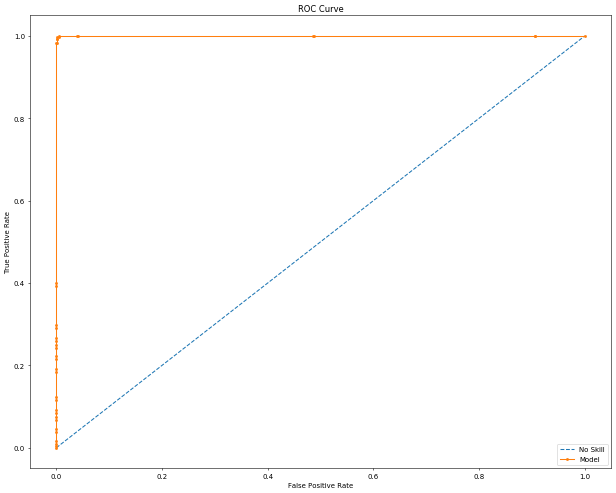

In [17]:
rl(util)
util.roc(lr_probs, testy, savefig='savefig/roc_resnet50.png')

Model: f1=0.001 auc=1.000


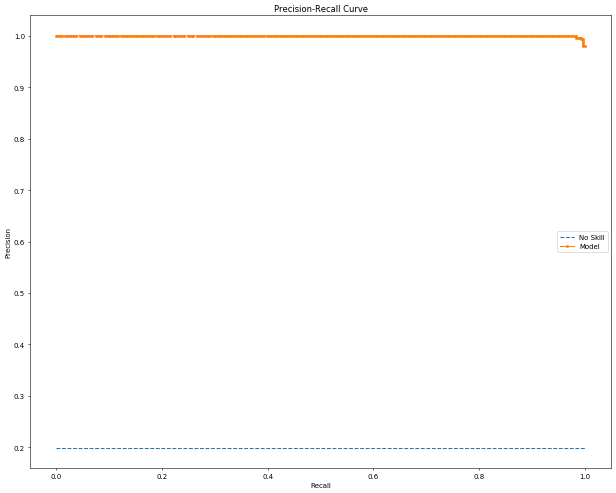

In [18]:
rl(util)
util.prc(pred_list,lr_probs, testy, savefig='savefig/prc_resnet50.png')

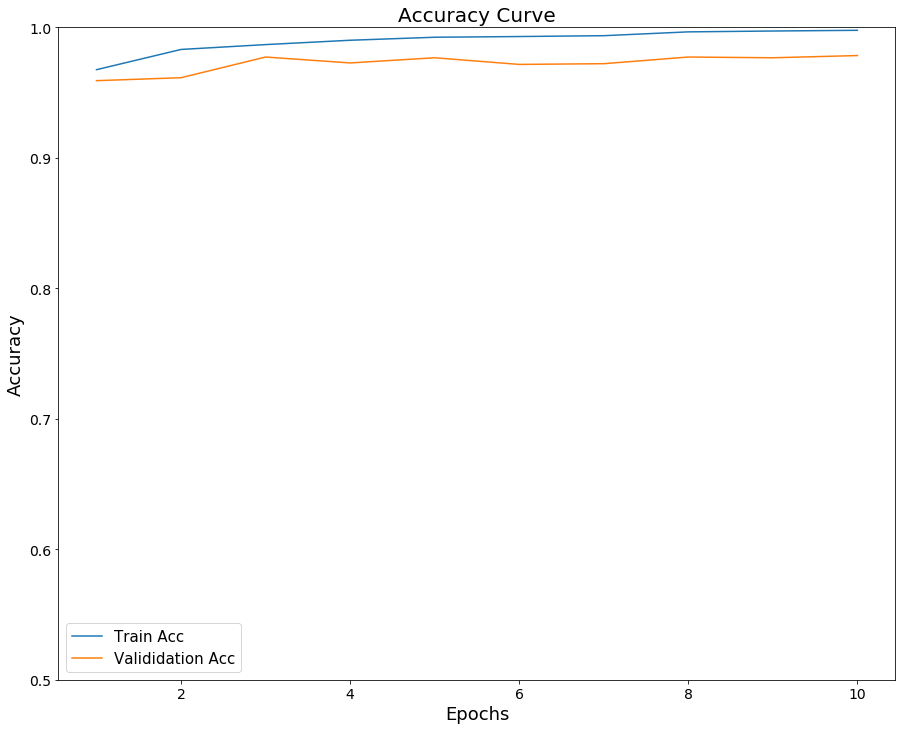

In [19]:
util.acc_curve(hist, savefig='binary_acc')

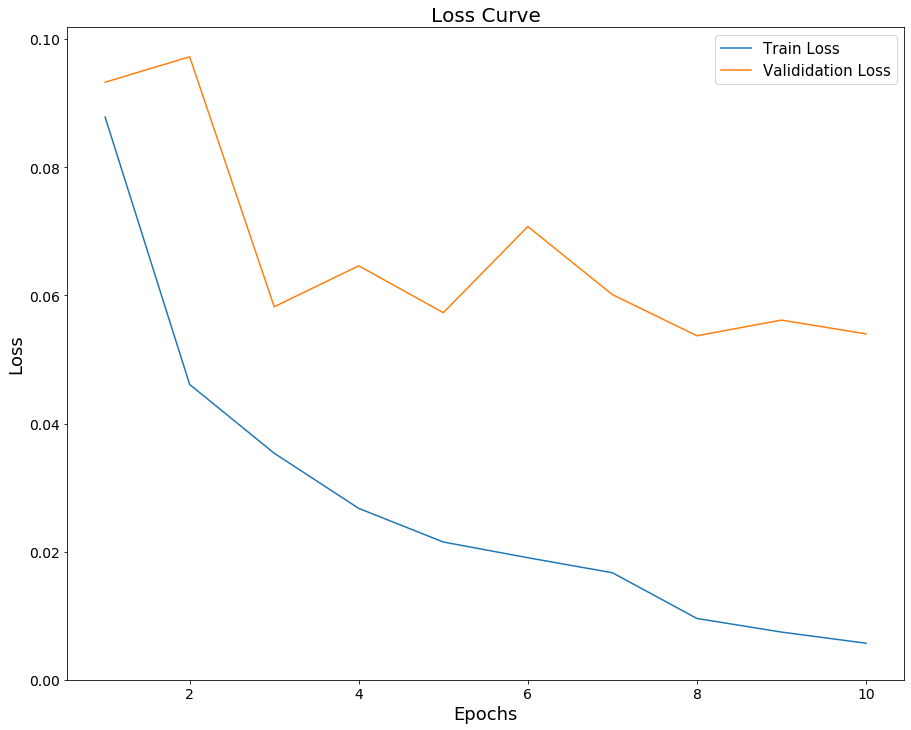

In [20]:
util.loss_curve(hist, savefig='binary_loss')